# Event Recognition: Physical Activity Bouts

This notebook demonstrates how to recognize physical activity bouts of light and moderate-vigorous physical activity from sensor event data in the OCED-mHealth format. We use one day of data as an example. 

<p> It follows a classical approach of human activity recognition based on a decision tree technique, using: 
<ul> 
    <li> Accelerometer values for threshold decision rules; and 
    <li> heart rate for labeling invalid readings (no-wear periods, errors, etc). 
</ul>
<p> Our approach follows: [https://doi.org/10.1038/s41598-019-54267-y] and [DOI: 10.1038/srep45772]

## Setup

First, let's set up our environment and import the necessary modules.

In [2]:
import datetime
import sys
# Add the project root directory to the Python path
sys.path.append('..')
from concurrent.futures import ThreadPoolExecutor
from src.oced.oced_data_query import OCEDDataQuery
from src.oced.time_objects import TimeObject
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import gc

## 1. Query OCED-mHealth Data to Retrieve Sensor Events 

Retrive acceleromenter and heart rate sensor events. 

In [3]:
# Get OCED-mHealth Data from JSON File
dataQuery = OCEDDataQuery()  
oced_data_file = f"oced_data_time.json"
data_dict = dataQuery.load_json(oced_data_file)

# Get sensor events data by type, filtering time
start_date = datetime.datetime(2025, 5, 11)
end_date = datetime.datetime(2025, 5, 12)

# Load accelerometer sensor events
accelerometer_data_df = dataQuery.get_accelerometer_events(data_dict,  start_date=start_date, end_date=end_date) # start_date=start_date, end_date=end_date)
accelerometer_data_df.head()

# Load heartrate sensor events
heartrate_data_df = dataQuery.get_heartrate_events(data_dict, start_date=start_date, end_date=end_date)
heartrate_data_df.head()

# (OPTIONAL) Save sensor events to JSON files
#import pandas as pd
#heartrate_data_df.to_json('hr_11-05-2025.json', orient='records', indent=4)
#accelerometer_data_df.to_json('acc_11-05-2025.json', orient='records', indent=4)

# Clean memory 
del data_dict
gc.collect()  # Force garbage collection

Date filtering parameters:
  Start date: 2025-05-11 00:00:00
  End date: 2025-05-12 00:00:00
Total number of sensor events found: 3969413
Available sensor event types: {'heartrate', 'location', 'activity_type', 'accelerometer'}
Number of accelerometer events found: 2902004
Date range of data before filtering:
  Earliest timestamp: 2025-05-09 08:51:06.728000
  Latest timestamp: 2025-05-14 22:52:11.561000
After start date filtering: 1953612 events remaining
After end date filtering: 621534 events remaining
Date filtering parameters:
  Start date: 2025-05-11 00:00:00
  End date: 2025-05-12 00:00:00
Total number of sensor events found: 3969413
Available sensor event types: {'heartrate', 'location', 'activity_type', 'accelerometer'}
Number of heartrate events found: 1056730
Date range of data before filtering:
  Earliest timestamp: 2025-05-09 08:51:26.735000
  Latest timestamp: 2025-05-21 10:55:41.609000
After start date filtering: 888140 events remaining
After end date filtering: 117311 ev

0

Inspect sensor attribute value distribution

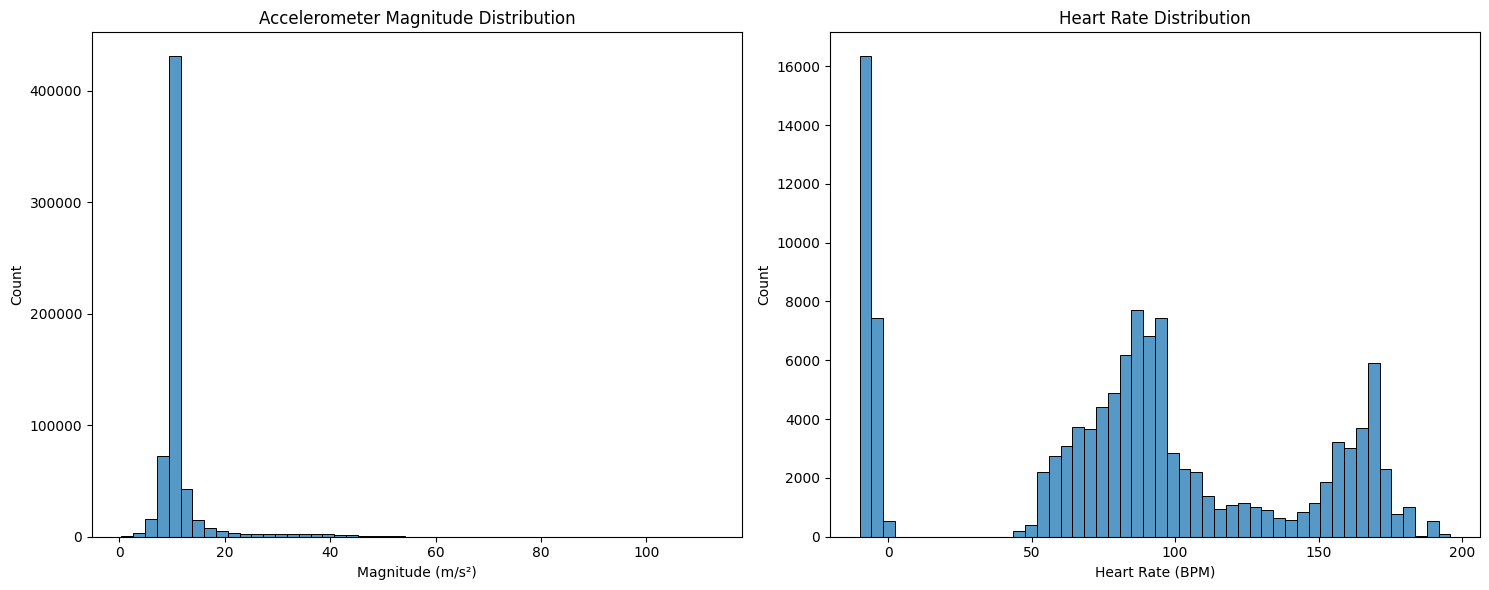


Accelerometer Magnitude Statistics:
Mean: 11.26 m/s²
Std: 5.40 m/s²
Min: 0.38 m/s²
Max: 112.49 m/s²
Median: 10.07 m/s²
Skewness: 4.48
Kurtosis: 23.25

Heart Rate Statistics:
Mean: 83.31 BPM
Std: 57.74 BPM
Min: -10.00 BPM
Max: 196.00 BPM
Median: 86.00 BPM
Skewness: -0.18
Kurtosis: -0.79


In [4]:
# Set up the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Calculate accelerometer magnitude
accelerometer_magnitude = np.sqrt(
    accelerometer_data_df['x']**2 + 
    accelerometer_data_df['y']**2 + 
    accelerometer_data_df['z']**2
)

# Plot accelerometer distribution
sns.histplot(data=accelerometer_magnitude, ax=ax1, bins=50)
ax1.set_title('Accelerometer Magnitude Distribution')
ax1.set_xlabel('Magnitude (m/s²)')
ax1.set_ylabel('Count')

# Plot heartrate distribution
sns.histplot(data=heartrate_data_df['bpm'], ax=ax2, bins=50)
ax2.set_title('Heart Rate Distribution')
ax2.set_xlabel('Heart Rate (BPM)')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Print statistics
print("\nAccelerometer Magnitude Statistics:")
print(f"Mean: {accelerometer_magnitude.mean():.2f} m/s²")
print(f"Std: {accelerometer_magnitude.std():.2f} m/s²")
print(f"Min: {accelerometer_magnitude.min():.2f} m/s²")
print(f"Max: {accelerometer_magnitude.max():.2f} m/s²")
print(f"Median: {np.median(accelerometer_magnitude):.2f} m/s²")
print(f"Skewness: {stats.skew(accelerometer_magnitude):.2f}")
print(f"Kurtosis: {stats.kurtosis(accelerometer_magnitude):.2f}")

print("\nHeart Rate Statistics:")
print(f"Mean: {heartrate_data_df['bpm'].mean():.2f} BPM")
print(f"Std: {heartrate_data_df['bpm'].std():.2f} BPM")
print(f"Min: {heartrate_data_df['bpm'].min():.2f} BPM")
print(f"Max: {heartrate_data_df['bpm'].max():.2f} BPM")
print(f"Median: {heartrate_data_df['bpm'].median():.2f} BPM")
print(f"Skewness: {stats.skew(heartrate_data_df['bpm']):.2f}")
print(f"Kurtosis: {stats.kurtosis(heartrate_data_df['bpm']):.2f}")

## 2. Resampling Sensor Events

The sampling frequency of the accelerometer and heart rate sensors are different and irregular. There is also missing data when sensors are not active. This is demonstrated by inspecting the time periods between two consecutive sensor events of the same type.  Resampling and synchronization are needed, as well as handling missing data. 


#### 2.1 Raw Sensor Data Analysis

Inspecting the distribution of data values and time intervals between two consecutive values. 
<p> The plots and stats below demonstrate that, for each sensor type: 
<ul>
    <li> The sampling frequency is approximately related to the median time intervants between two consecutive sensor events. (12.5 Hz for heartrate and 50 Hz for accelerometer)
    <li> More than 99% of time intervals are below 1 second. 
    <li> Assuming a data gap as time interval above 1 second without any sensor event, there are over 100 gaps in a day. 
    <li> Data gaps have mean durations over 1 minute (around 5 minutes on this particular day). 
    <li> Data gaps are justified by the lifecycle of the mHealth app: particularly, it activates sensors on pedometer change. Hence, resting periods are more dense in data gaps. For recongizing physical activity bouts, these data gaps are not critical but require considerations (e.g., smoothing techniques, filtering the valid values in a time-window)

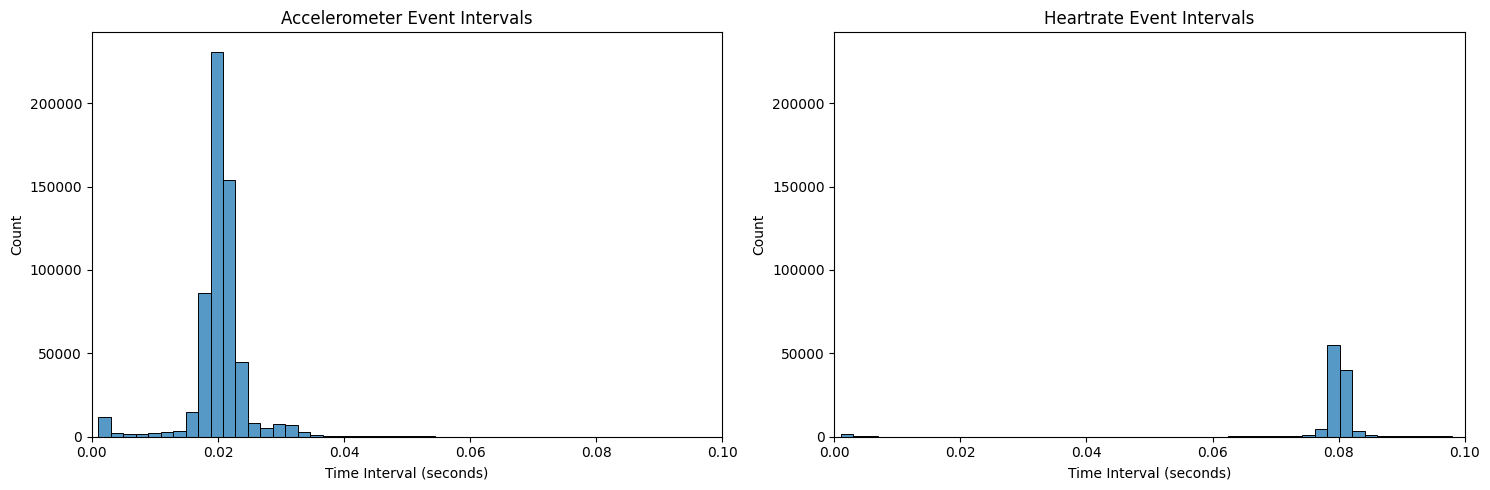


Statistics for Accelerometer intervals (all data):
Total number of intervals: 592,778
Mean interval: 0.087 seconds
Median interval: 0.020 seconds
Standard deviation: 5.748 seconds
Minimum interval: 0.001 seconds
Maximum interval: 1016.301 seconds
95th percentile: 0.026 seconds
99th percentile: 0.036 seconds

Interval distribution:
Intervals ≤ 0.1 seconds: 591,540 (99.79%)
Intervals > 0.1 seconds: 1,238 (0.21%)
Intervals > 1 second: 218 (0.04%)
Intervals > 10 seconds: 194 (0.03%)

Statistics for Heartrate intervals (all data):
Total number of intervals: 115,179
Mean interval: 0.450 seconds
Median interval: 0.080 seconds
Standard deviation: 14.018 seconds
Minimum interval: 0.001 seconds
Maximum interval: 1881.523 seconds
95th percentile: 0.083 seconds
99th percentile: 0.129 seconds

Interval distribution:
Intervals ≤ 0.1 seconds: 113,284 (98.35%)
Intervals > 0.1 seconds: 1,895 (1.65%)
Intervals > 1 second: 224 (0.19%)
Intervals > 10 seconds: 201 (0.17%)

Gap Analysis for Accelerometer:


In [13]:
# Calculate intervals for both sensor types
def calculate_time_intervals(df):
    """Calculate time intervals between consecutive events in seconds."""
    # Sort by timestamp to ensure correct order
    df = df.sort_values('timestamp')
    # Calculate time differences in seconds
    intervals = df['timestamp'].diff().dt.total_seconds()
    # Remove the first row (NaN) and any negative intervals (shouldn't exist)
    intervals = intervals[intervals > 0]
    return intervals
accel_intervals = calculate_time_intervals(accelerometer_data_df)
hr_intervals = calculate_time_intervals(heartrate_data_df)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Filter intervals <= 0.1 seconds for visualization only
accel_filtered = accel_intervals[accel_intervals <= 0.1]
hr_filtered = hr_intervals[hr_intervals <= 0.1]

# Plot histograms without KDE
sns.histplot(data=accel_filtered, bins=50, ax=ax1, kde=False)
ax1.set_title('Accelerometer Event Intervals')
ax1.set_xlabel('Time Interval (seconds)')
ax1.set_ylabel('Count')
ax1.set_xlim(0, 0.1)  # Limit x-axis to 0.1 second

sns.histplot(data=hr_filtered, bins=50, ax=ax2, kde=False)
ax2.set_title('Heartrate Event Intervals')
ax2.set_xlabel('Time Interval (seconds)')
ax2.set_ylabel('Count')
ax2.set_xlim(0, 0.1)  # Limit x-axis to 0.1 second

# Set the same y-axis limits for both plots
max_count = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(0, max_count)
ax2.set_ylim(0, max_count)

plt.tight_layout()
plt.show()

# Calculate and print statistics using ALL data points
def print_statistics(intervals, sensor_type):
    print(f"\nStatistics for {sensor_type} intervals (all data):")
    print(f"Total number of intervals: {len(intervals):,}")
    print(f"Mean interval: {intervals.mean():.3f} seconds")
    print(f"Median interval: {intervals.median():.3f} seconds")
    print(f"Standard deviation: {intervals.std():.3f} seconds")
    print(f"Minimum interval: {intervals.min():.3f} seconds")
    print(f"Maximum interval: {intervals.max():.3f} seconds")
    print(f"95th percentile: {np.percentile(intervals, 95):.3f} seconds")
    print(f"99th percentile: {np.percentile(intervals, 99):.3f} seconds")
    
    # Print distribution of intervals
    print(f"\nInterval distribution:")
    print(f"Intervals ≤ 0.1 seconds: {len(intervals[intervals <= 0.1]):,} ({len(intervals[intervals <= 0.1])/len(intervals)*100:.2f}%)")
    print(f"Intervals > 0.1 seconds: {len(intervals[intervals > 0.1]):,} ({len(intervals[intervals > 0.1])/len(intervals)*100:.2f}%)")
    print(f"Intervals > 1 second: {len(intervals[intervals > 1]):,} ({len(intervals[intervals > 1])/len(intervals)*100:.2f}%)")
    print(f"Intervals > 10 seconds: {len(intervals[intervals > 10]):,} ({len(intervals[intervals > 10])/len(intervals)*100:.2f}%)")

print_statistics(accel_intervals, "Accelerometer")
print_statistics(hr_intervals, "Heartrate")

# Additional analysis: Check for gaps in the data
def analyze_gaps(intervals, sensor_type, threshold_seconds=60):
    gaps = intervals[intervals > threshold_seconds]
    print(f"\nGap Analysis for {sensor_type}:")
    print(f"Number of gaps > {threshold_seconds} seconds: {len(gaps):,}")
    if len(gaps) > 0:
        print(f"Largest gap: {gaps.max():.1f} seconds")
        print(f"Average gap duration: {gaps.mean():.1f} seconds")

analyze_gaps(accel_intervals, "Accelerometer")
analyze_gaps(hr_intervals, "Heartrate")

In [14]:
# Calculate actual sampling frequency of each sensor
acc_sample_f = 1/accel_intervals.median()
hr_sample_f = 1/hr_intervals.median()

#### 2.2. Resample and synchronize sensors in one DataFrame, using linear interpolation.

<ul>
    <li>We have sensor data (like accelerometer or heart rate) that was sampled at irregular intervals</li>
    <li>We want to create a new df where all sensors have data points at exactly the same timestamps (synchronized)</li>
    <li>For timestamps where we don't have actual sensor readings, we estimate the values using linear interpolation</li>
</ul>

The actual sampling frequencies of the accelerometer and heartrate sensors seem to be 50 Hz and 12.5 Hz. Studies have show that for physical activity level classification purposes, downsampling to 25 Hz does not significantly impact the robustness of outcomes. <I>[doi: 10.3390/bioengineering12010018.]</I>

<p> For simplicity, we resample the data into alignment with linear interpolation. We downsample the acc to a sampling freq of 25 Hz, and we upsample the hr to 25 Hz. We store sync events with a timestamp and the value of each sensor attribute.

<p> <b> Important! </b> Handling data gaps/ missing data: We assume data gaps as time intervals > 1 second. In resampling, sync timestamps with no real sensor values within 1 second interval are assigned an INVALID flag. 

In [15]:
from src.oced.data_resampling import SensorDataResampler

# Initialize and synchronize as before
sensor_abstraction = SensorDataResampler(
    accelerometer=accelerometer_data_df,
    heartrate=heartrate_data_df
)

sync_df = sensor_abstraction.resample_and_sync_sensors(sampling_freq=25, max_gap_seconds=1.0)
sync_df.head()

c:\Users\20236075\OneDrive - TU Eindhoven\Documents\GitHub\GameBus-HealthBehaviorMining\notebooks\..\src\oced\data_resampling.py:185: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-3.92889503 -4.03286302 -4.04626298 ... -3.76848766 -3.75648407
 -3.76220076]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sync_df.loc[valid_mask, col_name] = interpolated_values
c:\Users\20236075\OneDrive - TU Eindhoven\Documents\GitHub\GameBus-HealthBehaviorMining\notebooks\..\src\oced\data_resampling.py:185: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6.19992318 6.19920528 6.12801886 ... 6.48038792 6.52530994 6.48865134]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sync_df.loc[valid_mask, col_name] = interpolated_values
c:\Users\20236075\OneDrive - TU

,accelerometer_x,accelerometer_y,accelerometer_z,heartrate_bpm,heartrate_pp
timestamp,,,,,
2025-05-11 08:44:46.363,-3.928895,6.199923,-6.496394,60.0,0.0
2025-05-11 08:44:46.403,-4.032863,6.199205,-6.479165,60.0,0.0
2025-05-11 08:44:46.443,-4.046263,6.128019,-6.423532,60.0,0.0
2025-05-11 08:44:46.483,-4.187439,6.096912,-6.376872,60.0,0.0
2025-05-11 08:44:46.523,-4.177868,5.929414,-6.168697,60.0,0.0


#### 2.3. Investigate sync data quality

As seen before, there is a large number of gaps / INVALID periods. 

<p>Reason for invalid data: The method identifies "valid segments" by looking for gaps larger than max_gap_seconds (default 1.0 second).
When it finds a gap larger than max_gap_seconds, it marks ALL data points between the end of one valid segment and the start of the next as invalid.
This means that even if you have 99% of your data with small intervals, a single gap > 1 second will create a large block of invalid data points.  

c:\Users\20236075\OneDrive - TU Eindhoven\Documents\GitHub\GameBus-HealthBehaviorMining\notebooks\..\src\oced\data_resampling.py:439: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  transitions = np.where(combined_mask.diff().fillna(False))[0]


               start_time                end_time  duration_seconds
0 2025-05-11 08:45:30.003 2025-05-11 08:59:51.203            861.20
1 2025-05-11 09:00:41.403 2025-05-11 09:04:19.443            218.04
2 2025-05-11 09:05:08.563 2025-05-11 09:16:04.883            656.32
3 2025-05-11 09:16:42.923 2025-05-11 09:20:24.963            222.04
4 2025-05-11 09:21:24.723 2025-05-11 09:32:08.083            643.36


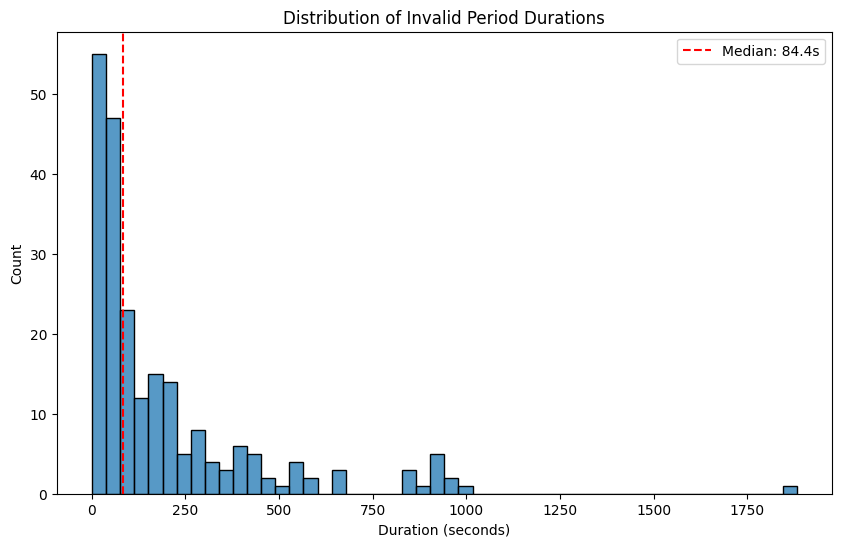


Duration Statistics:
Total periods: 222
Mean duration: 191.8 seconds
Median duration: 84.4 seconds
Max duration: 1881.5 seconds
Min duration: 1.0 seconds
Total duration: 42579.5 seconds


In [16]:
# Get invalid periods for all sensors
invalid_periods_df = sensor_abstraction.get_invalid_periods_df(min_duration_seconds=1.0)
# Display the first few 
print(invalid_periods_df.head())
def plot_invalid_periods_hist(invalid_periods_df, bins=50, figsize=(10, 6)):
    """
    Plot a histogram of invalid period durations.
    
    Args:
        invalid_periods_df: DataFrame from get_invalid_periods_df()
        bins: Number of histogram bins (default: 50)
        figsize: Figure size tuple (default: (10, 6))
    """
    plt.figure(figsize=figsize)
    
    # Create histogram using seaborn
    sns.histplot(data=invalid_periods_df, x='duration_seconds', bins=bins)
    
    # Customize the plot
    plt.title('Distribution of Invalid Period Durations')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    
    # Add a vertical line for the mean
    median_duration = invalid_periods_df['duration_seconds'].median()
    plt.axvline(median_duration, color='red', linestyle='--', 
                label=f'Median: {median_duration:.1f}s')
    
    # Add legend
    plt.legend()
    
    # Show the plot
    plt.show()
    
    # Print some statistics
    print(f"\nDuration Statistics:")
    print(f"Total periods: {len(invalid_periods_df)}")
    print(f"Mean duration: {invalid_periods_df['duration_seconds'].mean():.1f} seconds")
    print(f"Median duration: {invalid_periods_df['duration_seconds'].median():.1f} seconds")
    print(f"Max duration: {invalid_periods_df['duration_seconds'].max():.1f} seconds")
    print(f"Min duration: {invalid_periods_df['duration_seconds'].min():.1f} seconds")
    print(f"Total duration: {invalid_periods_df['duration_seconds'].sum():.1f} seconds")
plot_invalid_periods_hist(invalid_periods_df)

## 3. Calibrate Accelerometer Values

We used the autocalibration method as described in: https://journals.physiology.org/doi/epdf/10.1152/japplphysiol.00421.2014. We assume rest periods when the vector magnitude of the accelerometer in units of gravity is below <0.013 g

In [17]:
from src.oced.acc_calibration import AccelerometerCalibrator

# Define your accelerometer column names
cols = ('accelerometer_x', 'accelerometer_y', 'accelerometer_z')

# Create a calibrator instance
calibrator = AccelerometerCalibrator(axis_cols=cols, fs=25, static_threshold=0.013, unit='m/s2')

# Calibrate the accelerometer data
gains, offsets = calibrator.calibrate(sync_df)


# Apply the calibration
df_calibrated = calibrator.apply_calibration(sync_df)



Static Window Detection Diagnostics:
Total windows analyzed: 924
Windows without invalid values: 925
Windows that passed static test: 100

Standard deviation statistics (in g):
Mean std across all axes: 0.0036
Min std: 0.0017
Max std: 0.0129
Current threshold: 0.0130

Calibration Results (after 50 iterations):
Gains: ['0.9933', '0.9825', '1.0079'] (should be close to 1.0)
Offsets: ['0.0026', '-0.0329', '-0.0065'] (should be close to 0.0)

Calibration Statistics:
Mean magnitude: 1.0000 (should be close to 1.0)
Std magnitude: 0.0026 (should be small)
Gain deviation from 1.0: ['0.0067', '0.0175', '0.0079']
Offset deviation from 0.0: ['0.0026', '0.0329', '0.0065']
Final error: 0.001969
Original data:
                         accelerometer_x  accelerometer_y  accelerometer_z  \
timestamp                                                                    
2025-05-11 08:44:46.363        -3.928895         6.199923        -6.496394   
2025-05-11 08:44:46.403        -4.032863         6.199205  

## 4. Accelerometer Feature Extraction

We experimented with two validated methods for classification of physical activity bouts. Both implement decision trees, but use different accelerometer features. 

<ul> 
<li>Method 1 --> Euclidean Norm Minus One (ENMO) [DOI: 10.1038/srep45772][https://www.nature.com/articles/s41598-019-54267-y#:~:text=new%20cut%20points%2C%20we%20found,validated%20using%20data%20from]
<li>Method 2 --> Vector Magniture (VM) and Acceleration Angle Relative to Vertical (angle) [https://journals.physiology.org/doi/epdf/10.1152/japplphysiol.00026.2015]



In [18]:
from src.oced.feature_extraction import FeatureExtractor

# Create a feature extractor with your data
extractor = FeatureExtractor(df_calibrated)
#Identify axis cols
axis_cols=('accelerometer_x', 'accelerometer_y', 'accelerometer_z')

# Accelerometer feature: vector magnitude
vm = extractor.calculate_vector_magnitude(axis_cols=axis_cols, output_col="VM_feature")

# Accelerometer feature: Euclidean Norm Minus One
enmo = extractor.calculate_enmo(axis_cols=axis_cols, output_col='ENMO_feature')

# Accelerometer feature: Acceleration Angle Relative to Vertical
angle = extractor.calculate_vertical_angle(axis_cols=axis_cols, vm_col="VM_feature", output_col='ANGLE_feature')

# Combined feature vector
featured_df = extractor.get_data_with_features()

c:\Users\20236075\OneDrive - TU Eindhoven\Documents\GitHub\GameBus-HealthBehaviorMining\notebooks\..\src\oced\feature_extraction.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.01184959 1.01486476 1.0071258  ... 0.99398144 0.99749382 0.99454247]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  vm.loc[valid_mask] = np.sqrt(squared_sum)
c:\Users\20236075\OneDrive - TU Eindhoven\Documents\GitHub\GameBus-HealthBehaviorMining\notebooks\..\src\oced\feature_extraction.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.01184959 0.01486476 0.0071258  ... 0.         0.         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  enmo.loc[valid_mask] = np.maximum(0, magnitude - 1)
c:\Users\20236075\OneDrive - TU Eindhoven\Documents\

## 5. Extract time-window feature statistics

From accelerometer features, and considering no-wear time from heart rate values < 40. 

In [19]:
# Calculate statistics for vector magnitude
vm_stats = extractor.calculate_windowed_statistics(
    window_seconds=5,
    target_col='VM_feature',
    hr_col='heartrate_bpm', 
    stats=['mean', 'std'],
    min_valid_percent=100
)

# Calculate statistics for ENMO
enmo_stats = extractor.calculate_windowed_statistics(
    window_seconds=5,
    target_col='ENMO_feature',
    hr_col='heartrate_bpm', 
    stats=['mean'],
    min_valid_percent=100
)

# Calculate statistics for vertical angle
angle_stats = extractor.calculate_windowed_statistics(
    window_seconds=15,
    target_col='ANGLE_feature',
    hr_col='heartrate_bpm', 
    stats=['mean'],
    min_valid_percent=100
)

## 6. Classify of PA Levels in time-windows



#### 6.1. Classification of Light PA and Moderate-Vigorous PA bouts (Method 1)


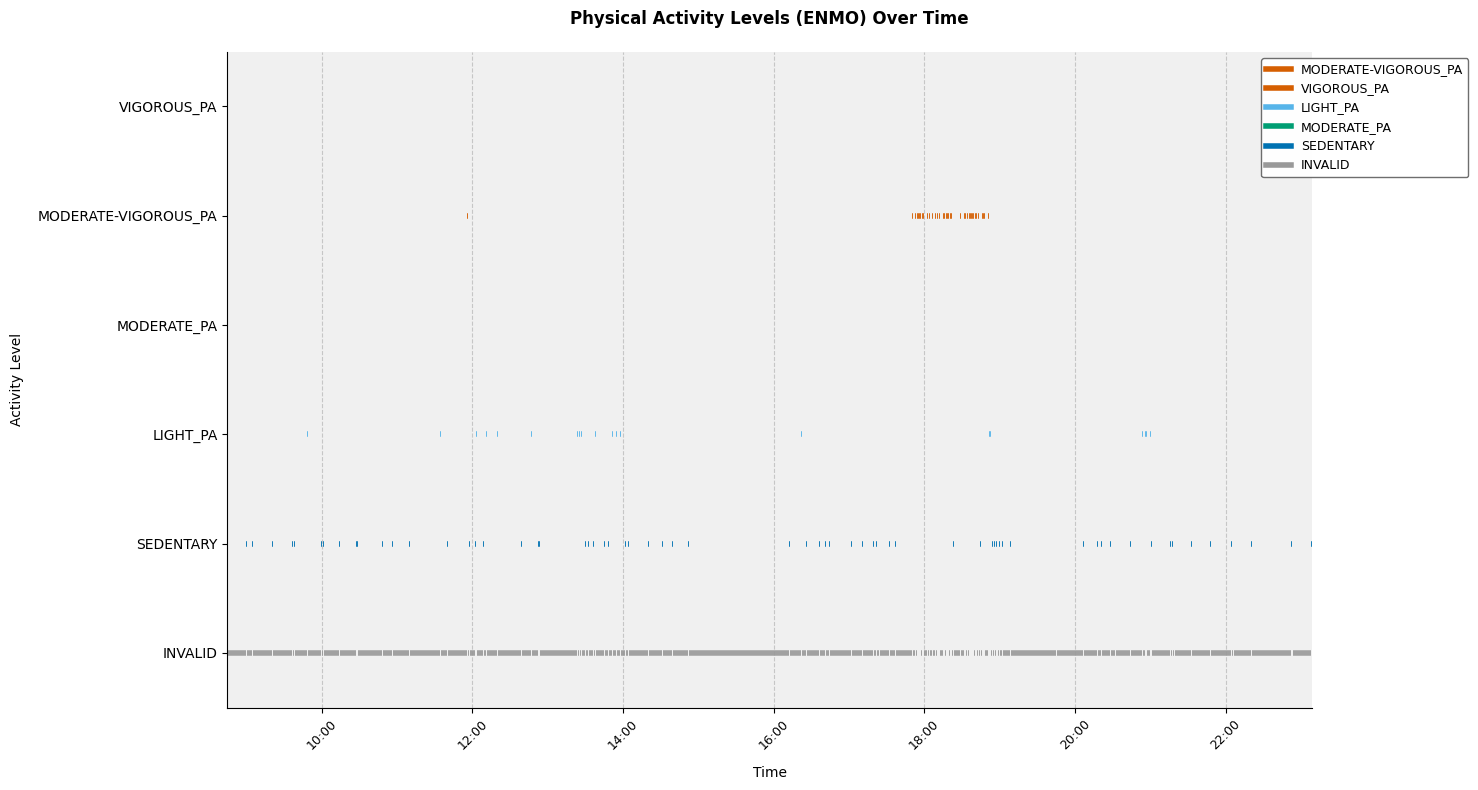

In [20]:
from src.oced.physical_activity_classifier import PhysicalActivityClassifier

# Classify the activity levels
classified_enmo_df = PhysicalActivityClassifier.classify_activity_levels_enmo(enmo_stats, enmo_column='ENMO_feature_mean')

# Then plot the results
PhysicalActivityClassifier.plot_activity_levels_enmo(classified_enmo_df, time_column='window_start', window_end_column='window_end', activity_column='activity_level_enmo')

#### 6.2. Classification of Light, Moderate and Vigorous PA bouts (Method 2)

In [21]:
import pandas as pd
# Combine feature statistics into a single dataframe
vm_stats_subset = vm_stats[['VM_feature_mean', 'VM_feature_std', 'window_start', 'window_end']]
angle_stats_subset = angle_stats[['ANGLE_feature_mean', 'window_start', 'window_end']]
combined_stats = pd.merge(vm_stats_subset, angle_stats_subset, 
                         on=['window_start', 'window_end'], 
                         how='outer')

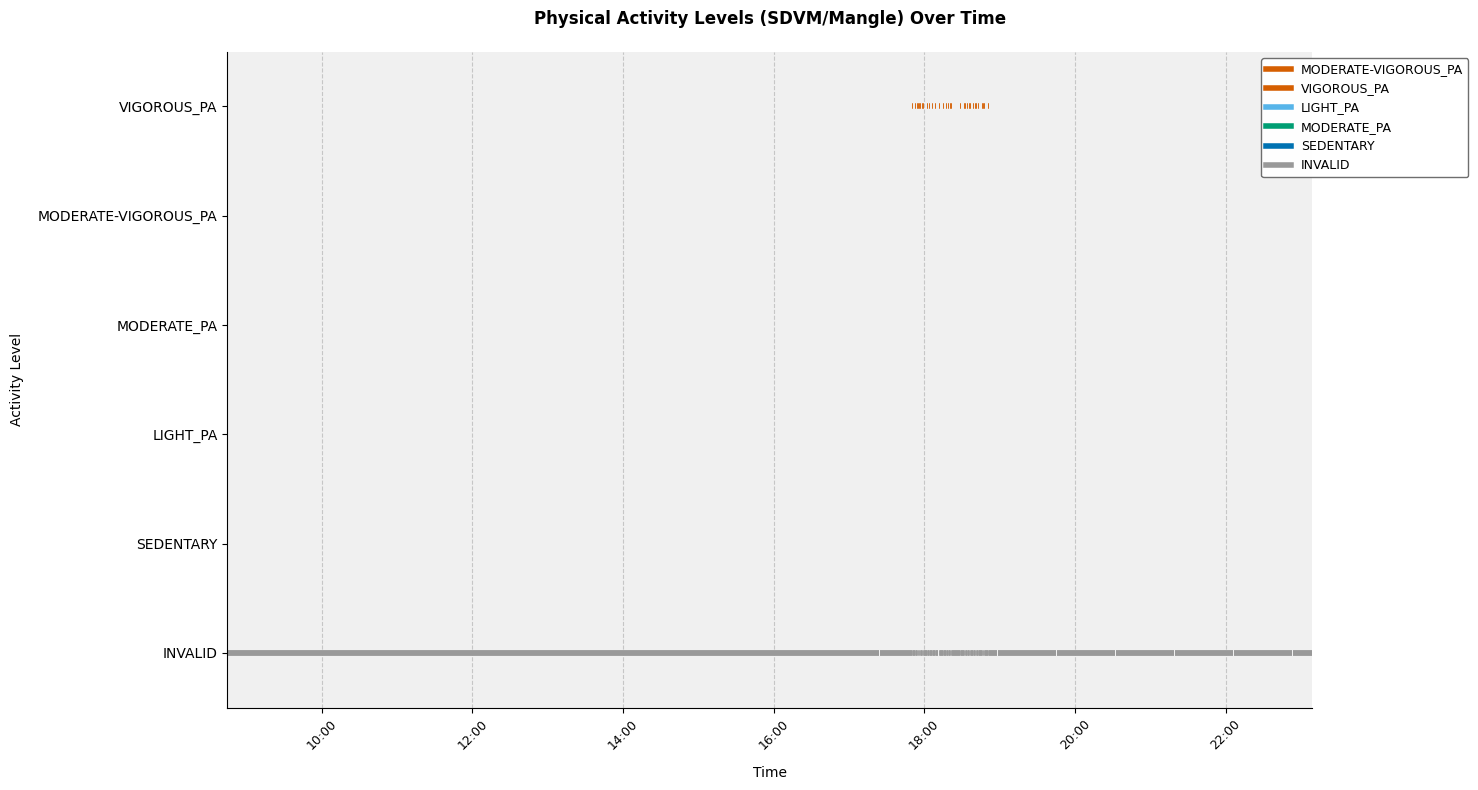

In [22]:
# Classify the activity levels
classified_sdvm_mangle_df = PhysicalActivityClassifier.classify_activity_levels_sdvm_mangle(combined_stats, sdvm_column='VM_feature_std', mangle_column='ANGLE_feature_mean')

# Then plot the results
PhysicalActivityClassifier.plot_activity_levels_sdvm_mangle(classified_sdvm_mangle_df, time_column='window_start', window_end_column='window_end', activity_column='activity_level_sdvm_mangle')

## 7. Smoothing Techniques - Segment MVPA bouts / events

We filter out invalid values up to a certain percentage and then use a majority vote. 

<p> The smoothing window is longer than the initial time-window epochs.

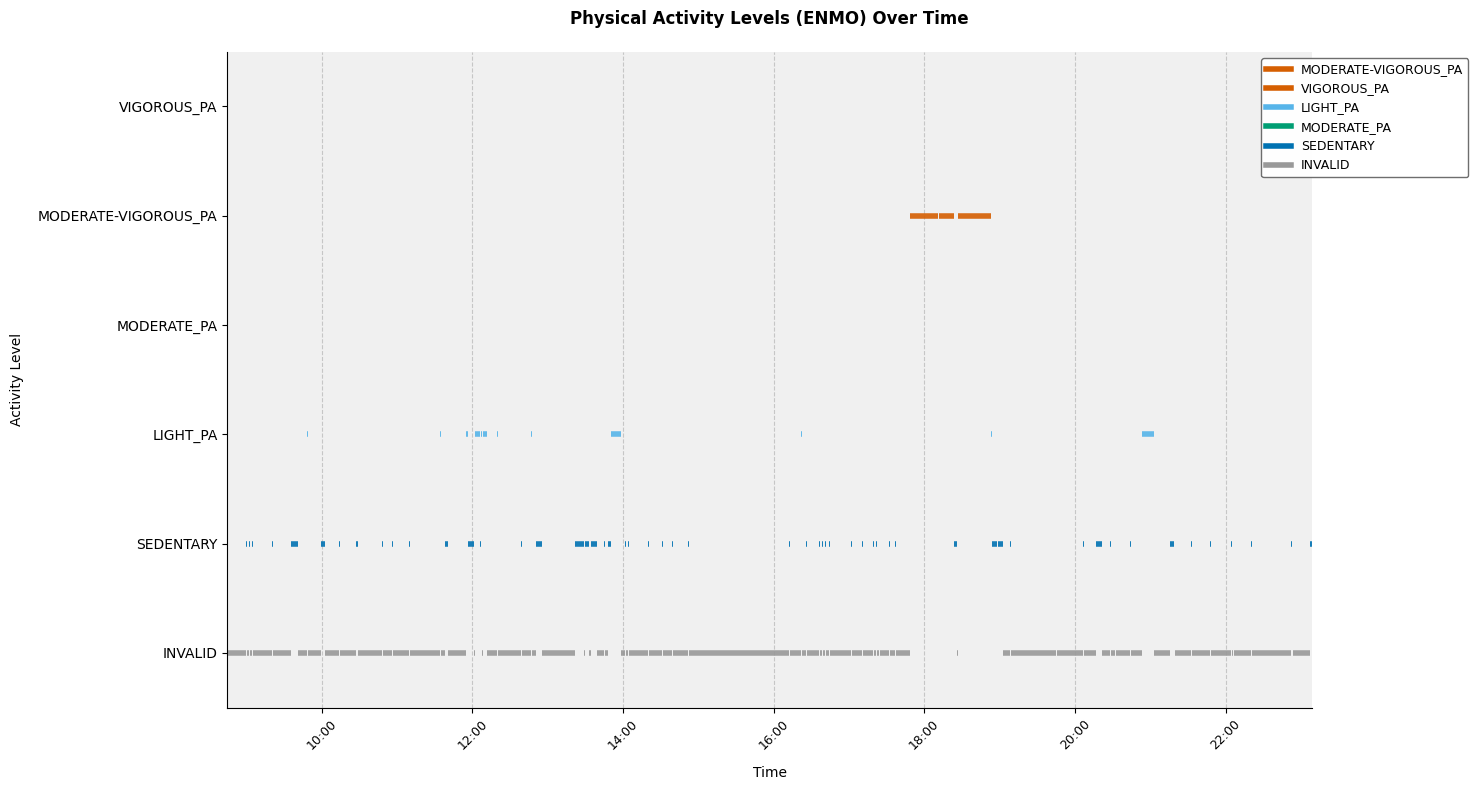

In [34]:
from src.oced.smoothing import SmoothingConfig, SmoothingClassifier

# Create configuration
config = SmoothingConfig(
    window_size=61,   
    invalid_threshold=0.8  
)

# Create classifier
smoother = SmoothingClassifier(config)

# Apply smoothing
smoothed_df = smoother.smooth(
    df=classified_enmo_df,
    class_column='activity_level_enmo',
    start_time_column='window_start',
    end_time_column='window_end'
)

PhysicalActivityClassifier.plot_activity_levels_enmo(smoothed_df, time_column='window_start', window_end_column='window_end', activity_column='smoothed_class')


## 8. Sustained PA Bouts/ Events Detection

In analysing physical activity behavior, it seems more interesting to investigate sustained periods of activity with a minumum duration, instead of small epochs (longer or equal to the smoothing window). 

<p> This allows to create events with a lower granularity.

In [33]:
from src.oced.bout_detection import BoutConfig, BoutDetector

# MVPA BOUTS
# Create configuration for bout detection
MVPA_bout_config = BoutConfig(
    min_duration=pd.Timedelta(minutes=1), 
    target_class='MODERATE-VIGOROUS_PA',  
    max_invalid_percentage=0.3,  
    min_valid_target_percentage=0.8,  
    invalid_class='INVALID'
)
# Create bout detector
MVPA_detector = BoutDetector(MVPA_bout_config)
# Detect bouts from smoothed data
MVPA_bouts_df = MVPA_detector.detect_bouts(
    df=smoothed_df,  # smoothed classification dataframe
    class_column='smoothed_class',
    start_time_column='window_start',
    end_time_column='window_end'
)
MVPA_bouts_df.head()

#LIGHT PA BOUTS
# Create configuration for bout detection
LIGHT_bout_config = BoutConfig(
    min_duration=pd.Timedelta(minutes=1),  # Minimum 10-minute bouts
    target_class='LIGHT_PA',  # Detect moderate activity bouts
    max_invalid_percentage=0.3,  # At most 30% can be invalid values
    min_valid_target_percentage=0.2,  # Within valid epochs, at least 80% must be target activity
    invalid_class='INVALID'
)
# Create bout detector
LIGHT_detector = BoutDetector(LIGHT_bout_config)
# Detect bouts from smoothed data
LIGHT_bouts_df = LIGHT_detector.detect_bouts(
    df=smoothed_df,  # smoothed classification dataframe
    class_column='smoothed_class',
    start_time_column='window_start',
    end_time_column='window_end'
)
LIGHT_bouts_df.head()

,bout_id,start_time,end_time,invalid_percentage,valid_target_percentage,duration
0,0,2025-05-11 12:04:06.363,2025-05-11 12:14:21.323,0.298387,0.942529,0 days 00:10:14.960000
1,1,2025-05-11 13:49:56.363,2025-05-11 14:00:51.323,0.295455,0.978495,0 days 00:10:54.960000
2,2,2025-05-11 20:53:36.363,2025-05-11 20:54:46.323,0.266667,0.818182,0 days 00:01:09.960000
3,3,2025-05-11 20:54:56.363,2025-05-11 21:04:51.323,0.300000,1.000000,0 days 00:09:54.960000


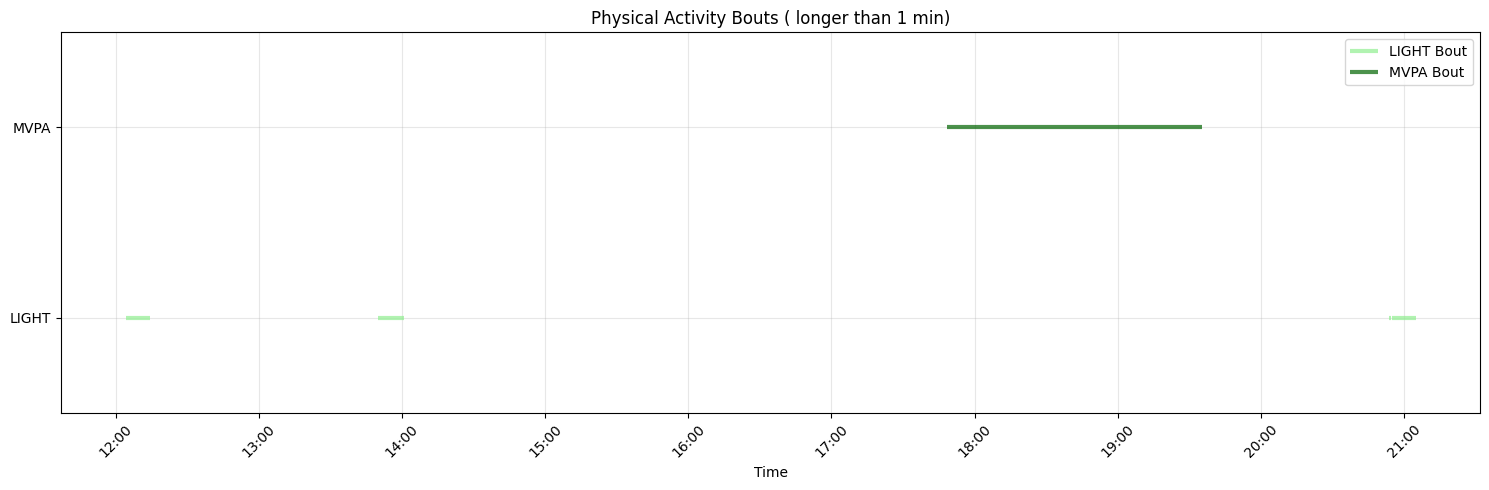

In [30]:
from src.oced.visualization import plot_activity_bouts

# Define colors for different activity classes
colors = {
    'LIGHT': 'lightgreen',
    'MVPA': 'darkgreen'
}

# Create a dictionary of bout DataFrames
bouts_dfs = {
    'LIGHT': LIGHT_bouts_df,  # Your DataFrame with light activity bouts
    'MVPA': MVPA_bouts_df    # Your DataFrame with MVPA bouts
}

# Plot the bouts
fig, ax = plot_activity_bouts(
    smoothed_df=smoothed_df,
    bouts_dfs=bouts_dfs,
    start_time_column='start_time',
    end_time_column='end_time',
    activity_classes=['LIGHT', 'MVPA'],
    colors=colors,
    figsize=(15, 5),
    title="Physical Activity Bouts ( longer than 1 min)"
)

# If you want to show the plot
plt.show()